<a href="https://colab.research.google.com/github/AhmedHeshamSakr/OCR-Models-Comparison-uesing-DL-/blob/main/OCR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import (Dense, Dropout, Conv2D, MaxPool2D, BatchNormalization, Flatten, GlobalAveragePooling2D, InputLayer) # type: ignore
from tensorflow.keras.preprocessing.image import ImageDataGenerator # type: ignore
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Reshape, Dense, Bidirectional, LSTM, Input, Flatten,TimeDistributed
from tensorflow.keras.models import Sequential # type: ignore
from tensorflow.keras.preprocessing import image # type: ignore
from keras.optimizers import Adam # type: ignore
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, LearningRateScheduler # type: ignore
from tensorflow.keras.preprocessing.image import load_img, img_to_array # type: ignore
from tensorflow.keras.models import Model # type: ignore
from tensorflow.keras.applications import VGG19 # type: ignore
from tensorflow.keras.applications import InceptionV3 # type: ignore
from tensorflow.keras.applications import ResNet50 # type: ignore
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications import MobileNetV3Large
from tensorflow.keras.mixed_precision import set_global_policy
from tensorflow.keras.mixed_precision import Policy
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report



from google.colab import files




In [ ]:
files.upload()

Saving ocr-dataset-metadata.json to ocr-dataset-metadata.json


{'ocr-dataset-metadata.json': b'{"@context":{"@language":"en","@vocab":"https://schema.org/","citeAs":"cr:citeAs","column":"cr:column","conformsTo":"dct:conformsTo","cr":"http://mlcommons.org/croissant/","data":{"@id":"cr:data","@type":"@json"},"dataBiases":"cr:dataBiases","dataCollection":"cr:dataCollection","dataType":{"@id":"cr:dataType","@type":"@vocab"},"dct":"http://purl.org/dc/terms/","extract":"cr:extract","field":"cr:field","fileProperty":"cr:fileProperty","fileObject":"cr:fileObject","fileSet":"cr:fileSet","format":"cr:format","includes":"cr:includes","isEnumeration":"cr:isEnumeration","isLiveDataset":"cr:isLiveDataset","jsonPath":"cr:jsonPath","key":"cr:key","md5":"cr:md5","parentField":"cr:parentField","path":"cr:path","personalSensitiveInformation":"cr:personalSensitiveInformation","recordSet":"cr:recordSet","references":"cr:references","regex":"cr:regex","repeated":"cr:repeated","replace":"cr:replace","sc":"https://schema.org/","separator":"cr:separator","source":"cr:sour

In [ ]:
!mkdir -p ~/.kaggle
!mv ocr-dataset-metadata.json ~/.kaggle/
!chmod 600 ~/.kaggle/ocr-dataset-metadata.json
!kaggle datasets download -d harieh/ocr-dataset
!unzip ocr-dataset.zip



Streaming output truncated to the last 5000 lines.
  inflating: dataset/y_L/Y_L_2535.png  
  inflating: dataset/y_L/Y_L_2536.png  
  inflating: dataset/y_L/Y_L_2537.png  
  inflating: dataset/y_L/Y_L_2538.png  
  inflating: dataset/y_L/Y_L_2539.png  
  inflating: dataset/y_L/Y_L_254.png  
  inflating: dataset/y_L/Y_L_2540.png  
  inflating: dataset/y_L/Y_L_2541.png  
  inflating: dataset/y_L/Y_L_2542.png  
  inflating: dataset/y_L/Y_L_2543.png  
  inflating: dataset/y_L/Y_L_2544.png  
  inflating: dataset/y_L/Y_L_2545.png  
  inflating: dataset/y_L/Y_L_2546.png  
  inflating: dataset/y_L/Y_L_2547.png  
  inflating: dataset/y_L/Y_L_2548.png  
  inflating: dataset/y_L/Y_L_2549.png  
  inflating: dataset/y_L/Y_L_255.png  
  inflating: dataset/y_L/Y_L_2550.png  
  inflating: dataset/y_L/Y_L_2551.png  
  inflating: dataset/y_L/Y_L_2552.png  
  inflating: dataset/y_L/Y_L_2553.png  
  inflating: dataset/y_L/Y_L_2554.png  
  inflating: dataset/y_L/Y_L_2555.png  
  inflating: dataset/y_L/Y_L_25

In [ ]:
def directory_to_df(path: str):
     df = []
     chars = 'abcdefghijklmnopqrstuvwxyz'  # to include lowercase letters only

     for cls in os.listdir(path):
        cls_path = os.path.join(path, cls)
        cls_name = cls.split('_')[0]  # Get the class name from the folder name
        if cls_name not in chars:
            continue  # Skip folders that do not start with a lowercase letter

        for img_file in os.listdir(cls_path):
            img_path = os.path.join(cls_path, img_file)
            df.append([img_path, cls_name])

     df = pd.DataFrame(df, columns=['image', 'label'])
     print("The number of samples found:", len(df))
     return df.copy()


def read_image(path):
    image = cv2.imread(path)
    if image is not None:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return image

def show_image(img, label=None) -> None:
    if img is not None:
        plt.imshow(img)
        plt.axis('off')
        if label:
            plt.title(label)
        plt.show()
    else:
        print("Image not found or cannot be read")

In [ ]:
!ls


dataset  DenseNet121_v3_model.h5  drive  ocr-dataset.zip  sample_data


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:


def clbck(model_name):
    # The function is defined to make the callbacks for training the models
    ERLY = EarlyStopping(patience=10, min_delta=0.01, start_from_epoch=10, verbose=1)
    RD = ReduceLROnPlateau(patience=5, min_delta=0.01, factor=0.5)
    CHK = ModelCheckpoint(f'/content/drive/My Drive/{model_name}_model.h5',verbose=1, save_best_only=True)
    return [ERLY,RD,CHK]

# Pre-defined hyperparameters
IMG_SHAPE = (32, 32)
IMG_SIZE = (32, 32, 3)
BATCH_SIZE = 32
opt = Adam(learning_rate=0.00001, epsilon=1e-6)
loss = 'categorical_crossentropy'
EPOCHS = 10


In [ ]:
# Reading the dataset into a DataFrame
main_path = 'dataset'
df = directory_to_df(main_path)
 # convert the dataset into df of two columns

print(df['label'].value_counts())

The number of samples found: 85199
label
e    3284
r    3284
n    3281
m    3281
a    3281
q    3279
u    3278
i    3277
d    3277
y    3276
s    3276
l    3276
t    3276
x    3276
k    3276
p    3275
f    3275
z    3275
h    3275
g    3275
o    3275
w    3275
c    3274
b    3274
v    3274
j    3274
Name: count, dtype: int64


In [ ]:

# Splitting for training & testing (70,30 respectively)
X, y = df['image'], df['label']
X_train, X_test, y_train, y_test = train_test_split(X,y , test_size=0.30, random_state=41)
training_df = pd.concat((X_train,y_train), axis=1)
testing_df = pd.concat((X_test,y_test), axis=1)

# Splitting for training & validation (75,25 respectively) -> the training set size = 52.5%
X, y = training_df['image'], training_df['label']
X_train, X_valid, y_train, y_valid = train_test_split(X,y , test_size=0.25, random_state=41)
training_df = pd.concat((X_train,y_train), axis=1)
validation_df = pd.concat((X_valid,y_valid), axis=1)

In [ ]:

# Creating generators
gen = ImageDataGenerator(dtype=np.int64, brightness_range=[0.0,1.0], fill_mode='nearest')
gen2 = ImageDataGenerator(dtype=np.int64, fill_mode='nearest')

train_gen = gen.flow_from_dataframe(training_df, x_col='image',y_col='label', batch_size=BATCH_SIZE,
                                   target_size=IMG_SHAPE)

valid_gen = gen2.flow_from_dataframe(validation_df, x_col='image', y_col='label', batch_size=BATCH_SIZE,
                                        target_size=IMG_SHAPE, shuffle=False)

test_gen = gen2.flow_from_dataframe(testing_df, x_col='image', y_col='label', batch_size=BATCH_SIZE,
                                       target_size=IMG_SHAPE, shuffle=False)

Found 44729 validated image filenames belonging to 26 classes.
Found 14910 validated image filenames belonging to 26 classes.
Found 25560 validated image filenames belonging to 26 classes.


In [ ]:
mapping = train_gen.class_indices
mapping_inverse = dict(map(lambda x: tuple(reversed(x)), mapping.items()))

print(mapping_inverse)

{0: 'a', 1: 'b', 2: 'c', 3: 'd', 4: 'e', 5: 'f', 6: 'g', 7: 'h', 8: 'i', 9: 'j', 10: 'k', 11: 'l', 12: 'm', 13: 'n', 14: 'o', 15: 'p', 16: 'q', 17: 'r', 18: 's', 19: 't', 20: 'u', 21: 'v', 22: 'w', 23: 'x', 24: 'y', 25: 'z'}


In [ ]:

train_layers = DenseNet121(include_top=False, input_shape=IMG_SIZE)
Den = Sequential()
Den.add(train_layers)
Den.add(Flatten())
Den.add(Dense(1024, activation='selu'))
Den.add(Dropout(0.5))
Den.add(Dense(512, activation='selu'))
Den.add(Dropout(0.5))
Den.add(BatchNormalization())
Den.add(Dense(len(mapping), activation='softmax'))

Den.summary()

29084464/29084464 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet121 (Functional)    (None, 1, 1, 1024)        7037504   
                                                                 
 flatten (Flatten)           (None, 1024)              0         
                                                                 
 dense (Dense)               (None, 1024)              1049600   
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 dense_1 (Dense)             (None, 512)               524800    
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                         

In [ ]:
optimizer = tf.keras.optimizers.legacy.Adam()
Den.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])
Den_T = Den.fit(train_gen, validation_data=valid_gen,  epochs=EPOCHS, callbacks=clbck('DenseNet121_v3'))

Epoch 1/10
1398/1398 [==============================] - ETA: 0s - loss: 0.7919 - accuracy: 0.7930
Epoch 1: val_loss improved from inf to 0.33230, saving model to /content/drive/My Drive/DenseNet121_v3_model.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1398/1398 [==============================] - 152s 91ms/step - loss: 0.7919 - accuracy: 0.7930 - val_loss: 0.3323 - val_accuracy: 0.9092 - lr: 0.0010
Epoch 2/10
1397/1398 [============================>.] - ETA: 0s - loss: 0.3719 - accuracy: 0.8992
Epoch 2: val_loss improved from 0.33230 to 0.25856, saving model to /content/drive/My Drive/DenseNet121_v3_model.h5
1398/1398 [==============================] - 102s 73ms/step - loss: 0.3723 - accuracy: 0.8992 - val_loss: 0.2586 - val_accuracy: 0.9281 - lr: 0.0010
Epoch 3/10
1398/1398 [==============================] - ETA: 0s - loss: 0.3006 - accuracy: 0.9198
Epoch 3: val_loss improved from 0.25856 to 0.24099, saving model to /content/drive/My Drive/DenseNet121_v3_model.h5
1398/1398 [==============================] - 100s 72ms/step - loss: 0.3006 - accuracy: 0.9198 - val_loss: 0.2410 - val_accuracy: 0.9304 - lr: 0.0010
Epoch 4/10
1398/1398 [==============================] - ETA: 0s - loss: 0.2718 - accuracy: 0.9254
Epoch 4: val_loss improved 

In [ ]:
Den.save('content/drive/My Drive/DenseNe_v3_model.h5')

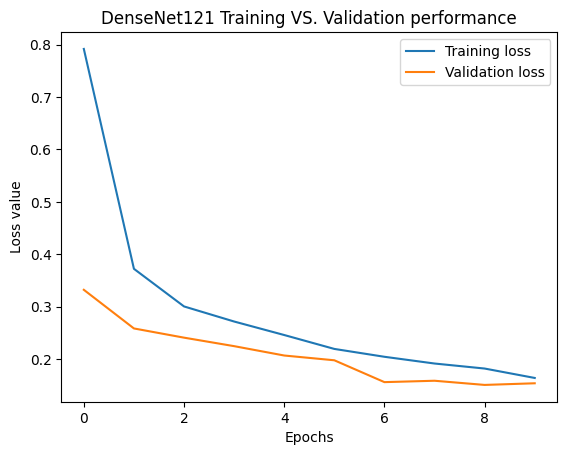

In [ ]:
plt.plot(Den_T.history['loss'], label='Training loss')
plt.plot(Den_T.history['val_loss'], label='Validation loss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss value')
plt.title("DenseNet121 Training VS. Validation performance")
plt.show()

In [ ]:

prediction = Den.predict(test_gen)
pred = list(map(lambda x: mapping_inverse[np.argmax(x)], prediction))
y_test = list(map(lambda x: mapping_inverse[x],test_gen.classes))

print('\t\tThe DenseNet121 Evaluation Performance')
print(classification_report(y_test, pred))

799/799 [==============================] - 20s 22ms/step
		The DenseNet121 Evaluation Performance
              precision    recall  f1-score   support

           a       0.95      0.96      0.96      1015
           b       0.97      0.97      0.97      1001
           c       0.98      0.89      0.93       980
           d       1.00      0.95      0.97      1003
           e       0.93      0.94      0.93       934
           f       0.93      0.97      0.95       990
           g       0.82      0.98      0.89      1045
           h       0.96      0.96      0.96      1009
           i       0.98      0.94      0.96      1001
           j       0.96      0.98      0.97       961
           k       0.98      0.97      0.98       973
           l       0.94      0.96      0.95       973
           m       0.98      0.98      0.98       981
           n       0.93      0.96      0.95       951
           o       0.95      0.94      0.94       952
           p       0.97      0.97    

In [ ]:

train_layers = ResNet50(include_top=False, input_shape=IMG_SIZE)
Res = Sequential()
Res.add(train_layers)
Res.add(Flatten())
Res.add(Dense(1024, activation='selu'))
Res.add(Dropout(0.5))
Res.add(Dense(512, activation='selu'))
Res.add(Dropout(0.5))
Res.add(BatchNormalization())
Res.add(Dense(len(mapping), activation='softmax'))

Res.summary()

94765736/94765736 [==============================] - 1s 0us/step
Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 1, 1, 2048)        23587712  
                                                                 
 flatten_10 (Flatten)        (None, 2048)              0         
                                                                 
 dense_34 (Dense)            (None, 1024)              2098176   
                                                                 
 dropout_16 (Dropout)        (None, 1024)              0         
                                                                 
 dense_35 (Dense)            (None, 512)               524800    
                                                                 
 dropout_17 (Dropout)        (None, 512)               0         
                                                      

In [ ]:
optimizer = tf.keras.optimizers.legacy.Adam()
Res.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])
Res_T = Res.fit(train_gen, validation_data=valid_gen,  epochs=EPOCHS, callbacks=clbck('ResNet50'))

Epoch 1/10
1398/1398 [==============================] - ETA: 0s - loss: 1.3197 - accuracy: 0.6562
Epoch 1: val_loss improved from inf to 1.62493, saving model to /content/drive/My Drive/ResNet50_model.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1398/1398 [==============================] - 96s 62ms/step - loss: 1.3197 - accuracy: 0.6562 - val_loss: 1.6249 - val_accuracy: 0.5325 - lr: 0.0010
Epoch 2/10
1398/1398 [==============================] - ETA: 0s - loss: 0.8246 - accuracy: 0.7849
Epoch 2: val_loss improved from 1.62493 to 0.54985, saving model to /content/drive/My Drive/ResNet50_model.h5
1398/1398 [==============================] - 90s 64ms/step - loss: 0.8246 - accuracy: 0.7849 - val_loss: 0.5498 - val_accuracy: 0.8549 - lr: 0.0010
Epoch 3/10
1397/1398 [============================>.] - ETA: 0s - loss: 0.4825 - accuracy: 0.8718
Epoch 3: val_loss improved from 0.54985 to 0.29912, saving model to /content/drive/My Drive/ResNet50_model.h5
1398/1398 [==============================] - 85s 61ms/step - loss: 0.4825 - accuracy: 0.8718 - val_loss: 0.2991 - val_accuracy: 0.9148 - lr: 0.0010
Epoch 4/10
1398/1398 [==============================] - ETA: 0s - loss: 0.4356 - accuracy: 0.8837
Epoch 4: val_loss did not improve from 0.2

In [ ]:

train_layers = MobileNetV3Large(include_top=False, input_shape=IMG_SIZE)
Eff = Sequential()
Eff.add(train_layers)
Eff.add(Flatten())
Eff.add(Dense(1024, activation='selu'))
Eff.add(Dropout(0.5))
Eff.add(Dense(512, activation='selu'))
Eff.add(Dropout(0.5))
Eff.add(BatchNormalization())
Eff.add(Dense(len(mapping), activation='softmax'))

Eff.summary()


12683000/12683000 [==============================] - 0s 0us/step


Exception ignored in: <function _xla_gc_callback at 0x78954e0f7520>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/jax/_src/lib/__init__.py", line 98, in _xla_gc_callback
    def _xla_gc_callback(*args):
KeyboardInterrupt: 


Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 MobilenetV3large (Function  (None, 1, 1, 960)         2996352   
 al)                                                             
                                                                 
 flatten_6 (Flatten)         (None, 960)               0         
                                                                 
 dense_22 (Dense)            (None, 1024)              984064    
                                                                 
 dropout_12 (Dropout)        (None, 1024)              0         
                                                                 
 dense_23 (Dense)            (None, 512)               524800    
                                                                 
 dropout_13 (Dropout)        (None, 512)               0         
                                                      

In [ ]:
optimizer = tf.keras.optimizers.legacy.Adam()
Eff.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])
Eff_t = Eff.fit(train_gen, validation_data=valid_gen,  epochs=EPOCHS, callbacks=clbck('MobileNet3'))


Epoch 1/10
1397/1398 [============================>.] - ETA: 0s - loss: 0.6732 - accuracy: 0.8227
Epoch 1: val_loss improved from inf to 2.18959, saving model to /content/drive/My Drive/MobileNet3_model.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1398/1398 [==============================] - 84s 54ms/step - loss: 0.6732 - accuracy: 0.8228 - val_loss: 2.1896 - val_accuracy: 0.7656 - lr: 0.0010
Epoch 2/10
1397/1398 [============================>.] - ETA: 0s - loss: 0.4331 - accuracy: 0.8832
Epoch 2: val_loss improved from 2.18959 to 0.48176, saving model to /content/drive/My Drive/MobileNet3_model.h5
1398/1398 [==============================] - 71s 50ms/step - loss: 0.4328 - accuracy: 0.8833 - val_loss: 0.4818 - val_accuracy: 0.8677 - lr: 0.0010
Epoch 3/10
1397/1398 [============================>.] - ETA: 0s - loss: 0.3520 - accuracy: 0.9048
Epoch 3: val_loss improved from 0.48176 to 0.33595, saving model to /content/drive/My Drive/MobileNet3_model.h5
1398/1398 [==============================] - 65s 46ms/step - loss: 0.3520 - accuracy: 0.9048 - val_loss: 0.3359 - val_accuracy: 0.9095 - lr: 0.0010
Epoch 4/10
1397/1398 [============================>.] - ETA: 0s - loss: 0.3272 - accuracy: 0.9123
Epoch 4: val_loss improved from 0.3359

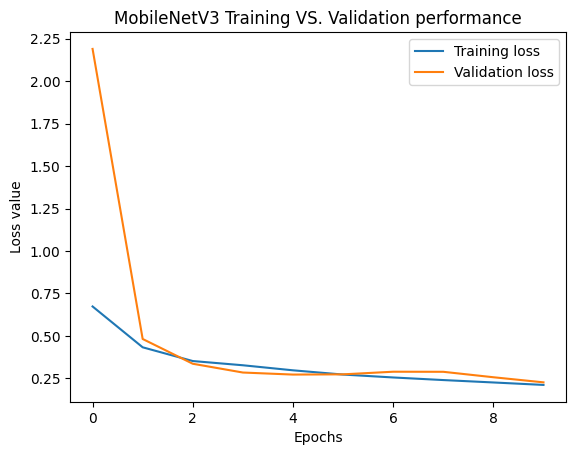

In [ ]:
plt.plot(Eff_t.history['loss'], label='Training loss')
plt.plot(Eff_t.history['val_loss'], label='Validation loss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss value')
plt.title("MobileNetV3 Training VS. Validation performance")
plt.show()

In [ ]:

prediction = Eff.predict(test_gen)
pred = list(map(lambda x: mapping_inverse[np.argmax(x)], prediction))
y_test = list(map(lambda x: mapping_inverse[x],test_gen.classes))

print('\t\tThe DenseNet121 Evaluation Performance')
print(classification_report(y_test, pred))

799/799 [==============================] - 16s 19ms/step
		The DenseNet121 Evaluation Performance
              precision    recall  f1-score   support

           a       0.84      0.97      0.90      1015
           b       0.97      0.94      0.96      1001
           c       0.94      0.93      0.93       980
           d       0.99      0.96      0.97      1003
           e       0.84      0.96      0.90       934
           f       1.00      0.91      0.95       990
           g       0.95      0.93      0.94      1045
           h       0.95      0.95      0.95      1009
           i       0.97      0.88      0.92      1001
           j       0.98      0.95      0.96       961
           k       0.96      0.95      0.95       973
           l       0.87      0.96      0.91       973
           m       0.84      0.98      0.91       981
           n       0.96      0.83      0.89       951
           o       0.96      0.94      0.95       952
           p       0.96      0.97    

In [ ]:
train_layers = EfficientNetB0(include_top=False, input_shape=IMG_SIZE)
E = Sequential()
E.add(train_layers)
E.add(Flatten())
E.add(Dense(1024, activation='selu'))
E.add(Dropout(0.5))
E.add(Dense(512, activation='selu'))
E.add(Dropout(0.5))
E.add(BatchNormalization())
E.add(Dense(len(mapping), activation='softmax'))

Eff.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 MobilenetV3large (Function  (None, 1, 1, 960)         2996352   
 al)                                                             
                                                                 
 flatten_6 (Flatten)         (None, 960)               0         
                                                                 
 dense_22 (Dense)            (None, 1024)              984064    
                                                                 
 dropout_12 (Dropout)        (None, 1024)              0         
                                                                 
 dense_23 (Dense)            (None, 512)               524800    
                                                                 
 dropout_13 (Dropout)        (None, 512)               0         
                                                      

In [ ]:
optimizer = tf.keras.optimizers.legacy.Adam()
E.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])
E_t = E.fit(train_gen, validation_data=valid_gen,  epochs=EPOCHS, callbacks=clbck('EfficientNetB0'))

Epoch 1/10
1398/1398 [==============================] - ETA: 0s - loss: 0.9560 - accuracy: 0.7426
Epoch 1: val_loss improved from inf to 0.29482, saving model to /content/drive/My Drive/EfficientNetB0_model.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1398/1398 [==============================] - 84s 52ms/step - loss: 0.9560 - accuracy: 0.7426 - val_loss: 0.2948 - val_accuracy: 0.9180 - lr: 0.0010
Epoch 2/10
1398/1398 [==============================] - ETA: 0s - loss: 0.4237 - accuracy: 0.8868
Epoch 2: val_loss improved from 0.29482 to 0.28618, saving model to /content/drive/My Drive/EfficientNetB0_model.h5
1398/1398 [==============================] - 73s 52ms/step - loss: 0.4237 - accuracy: 0.8868 - val_loss: 0.2862 - val_accuracy: 0.9234 - lr: 0.0010
Epoch 3/10
1398/1398 [==============================] - ETA: 0s - loss: 0.3573 - accuracy: 0.9044
Epoch 3: val_loss improved from 0.28618 to 0.22921, saving model to /content/drive/My Drive/EfficientNetB0_model.h5
1398/1398 [==============================] - 73s 52ms/step - loss: 0.3573 - accuracy: 0.9044 - val_loss: 0.2292 - val_accuracy: 0.9371 - lr: 0.0010
Epoch 4/10
1398/1398 [==============================] - ETA: 0s - loss: 0.3165 - accuracy: 0.9154
Epoch 4: val_loss improved fro

In [ ]:
prediction = E.predict(test_gen)
pred = list(map(lambda x: mapping_inverse[np.argmax(x)], prediction))
y_test = list(map(lambda x: mapping_inverse[x],test_gen.classes))

print('\t\tThe DenseNet121 Evaluation Performance')
print(classification_report(y_test, pred))

799/799 [==============================] - 16s 19ms/step
		The DenseNet121 Evaluation Performance
              precision    recall  f1-score   support

           a       0.93      0.96      0.95      1015
           b       0.97      0.98      0.97      1001
           c       0.95      0.96      0.95       980
           d       0.99      0.98      0.98      1003
           e       0.98      0.92      0.95       934
           f       0.98      0.96      0.97       990
           g       0.97      0.90      0.93      1045
           h       0.97      0.95      0.96      1009
           i       0.94      0.95      0.94      1001
           j       0.94      0.98      0.96       961
           k       0.98      0.92      0.95       973
           l       0.91      0.96      0.94       973
           m       0.93      0.97      0.95       981
           n       0.93      0.97      0.95       951
           o       0.95      0.96      0.96       952
           p       0.97      0.98    

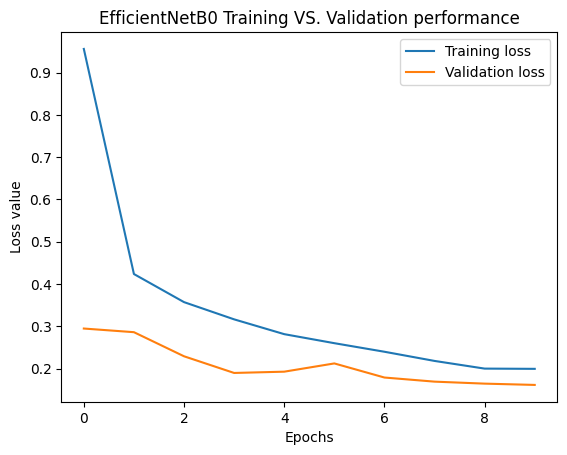

In [ ]:
plt.plot(E_t.history['loss'], label='Training loss')
plt.plot(E_t.history['val_loss'], label='Validation loss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss value')
plt.title("EfficientNetB0 Training VS. Validation performance")
plt.show()

In [ ]:
vals = {'accuracy':[0.94 , 0.94 , 0.89,0.96], 'precision':[0.96,0.94,0.90,0.96],
       'recall':[0.96,0.94,0.90,0.96], 'F1-Score':[0.96,0.94,0.91,0.96]}
results = pd.DataFrame(vals, index=['EfficientNetB0','MobileNetV3', 'ResNet50',
                                   'DenseNet121'])

print("\t\tThe Evaluation results of CNN/Pre-trained models")
print(results)

		The Evaluation results of CNN/Pre-trained models
                accuracy  precision  recall  F1-Score
EfficientNetB0      0.94       0.96    0.96      0.96
MobileNetV3         0.94       0.94    0.94      0.94
ResNet50            0.89       0.90    0.90      0.91
DenseNet121         0.96       0.96    0.96      0.96


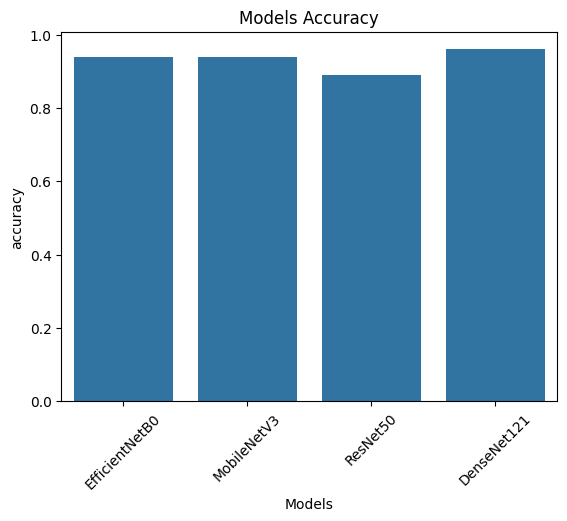

In [ ]:
sns.barplot(data=results, x=results.index, y='accuracy')
plt.xticks(rotation=45)
plt.xlabel('Models')
plt.title("Models Accuracy")
plt.show()

In [ ]:

def load_model():
    model_path = '/content/drive/MyDrive/DenseNet121_v3_model.h5'
    model = tf.keras.models.load_model(model_path)
    return model
def convert_2_gray(image):
    gray_image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    return gray_image

def binarization(image):
    img, thresh = cv2.threshold(image, 0,255, cv2.THRESH_OTSU|cv2.THRESH_BINARY_INV)
    return img, thresh

def dilate(image, words= False):
    img = image.copy()
    m = 3
    n = m - 2                   # n less than m for Vertical structuring element to dilate chars
    itrs = 4
    if words:
        m = 6
        n = m
        itrs = 3
    rect_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (n, m))
    dilation = cv2.dilate(img, rect_kernel, iterations = itrs)
    return dilation

def find_rect(image):
    contours, hierarchy = cv2.findContours(image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    rects = []

    for cnt in contours:
        x,y,w,h = cv2.boundingRect(cnt)  # Extract the bounding rectangle coordinates of each countour
        rects.append([x,y,w,h])

    sorted_rects = list(sorted(rects, key=lambda x: x[0])) # Sorting the rects from Left-to-Right
    return sorted_rects

def extract(image):
    model = load_model()
    chars = []              # a list to store recognized characters

    image_cpy = image.copy()
    _, bin_img = binarization(convert_2_gray(image_cpy))
    full_dil_img = dilate(bin_img,words=True)
    words = find_rect(full_dil_img)                       # Recognized words within the image
    del _, bin_img, full_dil_img                          # for better memory usage

    for word in words:
        x,y,w,h = word                                    # coordinates of the word
        img = image_cpy[y:y+h, x:x+w]

        _, bin_img = binarization(convert_2_gray(img))
        dil_img = dilate(bin_img)
        char_parts = find_rect(dil_img)                     # Recognized chars withtin the word
        cv2.rectangle(image, (x,y),(x+w,y+h), (0,255,0), 3) # draw a green rectangle around the word

        del _, bin_img, dil_img

        for char in char_parts:
            x,y,w,h = char
            ch = img[y:y+h, x:x+w]

            empty_img = np.full((32,32,1),255, dtype=np.uint8) # a white image used for resize with filling
            x,y = 3,3                                          # starting indecies
            resized = cv2.resize(ch, (16,22), interpolation=cv2.INTER_CUBIC)
            gray = convert_2_gray(resized)
            empty_img[y:y+22, x:x+16,0] = gray.copy()          # integrate the recognized char into the white image
            gray = cv2.cvtColor(empty_img, cv2.COLOR_GRAY2RGB)
            gray = gray.astype(np.int64)

            predicted = mapping_inverse[np.argmax(model.predict(np.array([gray]), verbose=-1))]
            chars.append(predicted)                            # append the character into the list

            del ch, resized, gray, empty_img
        chars.append(' ')  # at the end of each iteration (end of word) append a space

    del model
    show_image(image)
    return ''.join(chars[:-1])

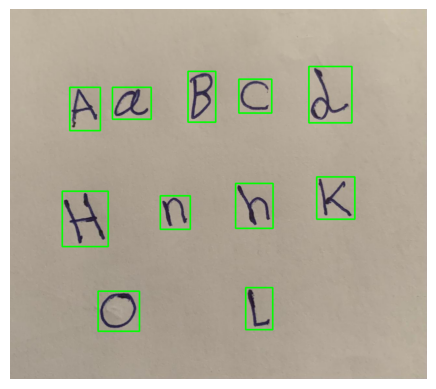

--> y p u d y b h l u n x


In [ ]:
# Testing 1


img = read_image('//content/drive/MyDrive/WhatsApp Image 2024-05-26 at 15.59.55.jpeg')
text = extract(img)
print('-->',text)

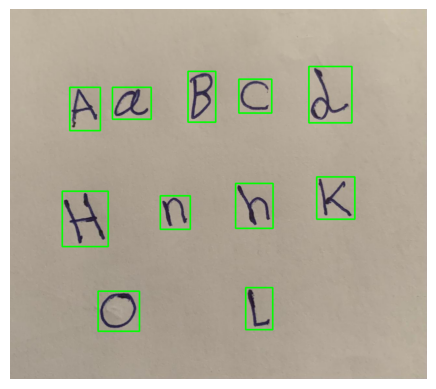

--> m n b l n b m l l b k


In [ ]:

def load_model():
    model_path = '/content/drive/MyDrive/EfficientNetB0_model.h5'
    model = tf.keras.models.load_model(model_path)
    return model

img = read_image('//content/drive/MyDrive/WhatsApp Image 2024-05-26 at 15.59.55.jpeg')
text = extract(img)
print('-->',text)

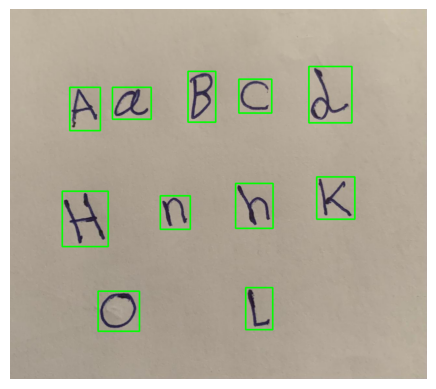

--> g p g l g g y g g b k


In [ ]:

def load_model():
    model_path = '/content/drive/MyDrive/MobileNet3_model.h5'
    model = tf.keras.models.load_model(model_path)
    return model

img = read_image('//content/drive/MyDrive/WhatsApp Image 2024-05-26 at 15.59.55.jpeg')
text = extract(img)
print('-->',text)